In [ ]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from typing_extensions import TypedDict


from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

from dotenv import load_dotenv

load_dotenv()

from langchain_tavily import TavilySearch

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 各種ノードの定義
# LLM
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
# ツール
tool = TavilySearch()
tools = [tool]
# LLMにツールを追加
llm_with_tools = llm.bind_tools(tools)



# 検索チャットノード
def search_node(state: State):
    system_prompt = """
    あなたは検索アシスタントです。query_nodeからのクエリに対して、Tavily検索を行い、検索結果を返してください。
    """
    messages_with_prompt = [{"role": "system", "content": system_prompt}] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages_with_prompt)]}

# 回答チャットノード
def answer_node(state: State):
    system_prompt = """
    あなたは回答生成アシスタントです。ユーザからの質問に対して、Tavily検索結果を元に回答を生成してください。
    出力形式はマークダウン形式で出力してください。
    引用元の記載にはURLのリンクもマークダウン形式で付与してください。
    """
    messages_with_prompt = [{"role": "system", "content": system_prompt}] + state["messages"]
    return {"messages": [llm.invoke(messages_with_prompt)]}

tool_node = ToolNode(tools=[tool])

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("search_node", search_node)
graph_builder.add_node("tool_node", tool_node)
graph_builder.add_node("answer_node", answer_node)
graph_builder.set_entry_point("search_node")


def should_continue(state: State) -> str:
    """
    最後のメッセージにツールコールがあるかどうかを判断する。
    """
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "continue"
    return "end"

# search_nodeの後に tool_node を挟み、再度回答生成へ
graph_builder.add_conditional_edges(
    "search_node",
    should_continue,
    {
        "continue": "tool_node",
        "end": "answer_node",
    },
)

# tool_nodeの後はanswer_nodeに戻る
graph_builder.add_edge("tool_node", "answer_node")

# 回答ノードの後はENDに戻る
graph_builder.add_edge("answer_node", END)

graph = graph_builder.compile()

def search_agent(question: str):
    return graph.invoke({"messages": [HumanMessage(content=question)]})



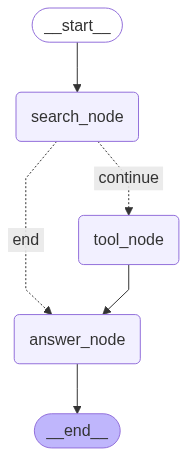

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass